In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import os
import json
import matplotlib.pyplot as plt
import PIL
import read_datasets as rd
import constants as CONST
from importlib import reload
reload(rd)
reload(CONST)
import base64
import pickle
import collections
import itertools, collections
from sklearn.metrics import mean_squared_error
import cv2 

In [2]:
import torch

In [3]:
np.set_printoptions(precision=4, suppress=True)

In [10]:
w = h = 64
TEMPLATE_DICT = {
    'arc' : lambda n : rd.generate_arc(n1=n, radius=100, x0=100, y0=100, template_size=w),
    'circle' : lambda n : rd.generate_circle(n1=n, radius=100, x0=100, y0=100, template_size=w),
    'square' : lambda n : rd.generate_square(n1=n, template_size=w),
    'semicircle' : lambda n : rd.generate_semicircle(n1=n, radius=100, x0=100, y0=100, template_size=w),
    'zigzag3' : lambda n : rd.generate_zigzag3(n1=n, template_size=w),
    'zigzag1' : lambda n : rd.generate_zigzag1(n1=n, template_size=w),
}

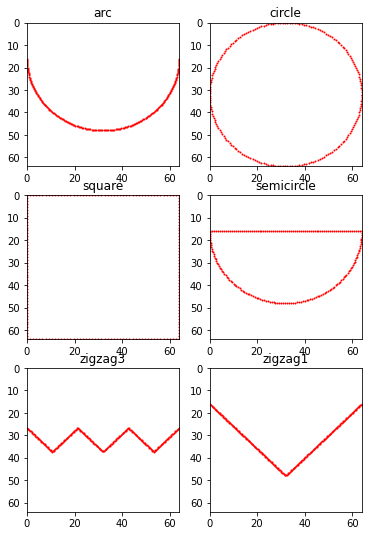

In [11]:
n=200
num_pngs_per_row = 2
row_figsize = 3
column_figsize = 3

num_rows = len(TEMPLATE_DICT) // num_pngs_per_row
if num_rows * num_pngs_per_row < len(TEMPLATE_DICT):
    num_rows += 1

fig = plt.figure(figsize=(num_pngs_per_row * row_figsize, num_rows * column_figsize)) 
fig.patch.set_alpha(1)  # solution

for index, (template_name, template_func) in enumerate(TEMPLATE_DICT.items()):
    template = template_func(n)

    plt.subplot(num_rows, num_pngs_per_row, index+1)
    plt.scatter(template[:,0], template[:,1], s=1, c='r')
    plt.title(template_name)
    # plt.axis('off')
    plt.xlim(0,w)
    plt.ylim(h,0)

plt.show()
plt.close()

In [22]:
drawing_arr = CONST.face_json['train_data']
n = 200
h,w = 256,256

In [7]:
# reload(rd)
# prim = rd.generate_zigzag3()
# # prim = rd.interpcurve(200, prim[:,0], prim[:,1])
# # np.sqrt(np.sum((prim[1:]-prim[:-1])**2,axis=1)) 

# plt.figure(figsize=(12,12))
# plt.scatter(prim[:,0], prim[:,1], s=1, c='r')
# h,w = 256,256
# plt.xlim(0,w)
# plt.ylim(h,0)
# plt.show()

In [ ]:
from tqdm import tqdm

use_projective = True

M_arr = collections.defaultdict(lambda : np.zeros(9))
M_name = collections.defaultdict(lambda : " ")
M_mse = collections.defaultdict(float)

b_spline_num_sampled_points = n

for idx in tqdm(range(len(drawing_arr))):
    strokes_spline_fitted = rd.process_quickdraw_to_stroke_no_normalize(
        drawing_arr[idx], 
        b_spline_num_sampled_points=200,
    )
    
    for stroke_index, data in enumerate(strokes_spline_fitted):
        
        mat, prim_name, prim_mse = rd.get_transform_smallest_mse(
            data, rd.TEMPLATE_DICT, n=200, use_projective=True
        )
        M_arr[(idx, stroke_index)] = mat
        M_name[(idx, stroke_index)] = prim_name
        M_mse[(idx, stroke_index)] = prim_mse
        
#         min_template_name, min_template_mse = None, np.inf
#         min_M = None
#         for template_name, template_func in rd.TEMPLATE_DICT.items():
#             template = template_func(n)
#             try:
#                 M, result = rd.get_transform(template, data, projective=use_projective)
#             except:
#                 try:
#                     mask = np.zeros(len(data))
#                     mask[:20] = 1
#                     np.random.shuffle(mask)
#                     data = data + (np.random.normal(0, 0.05, len(data)) * mask).reshape(-1,1)
#                     M, result = rd.get_transform(template, data, projective=use_projective)
#                 except:
#                     continue
#             mse = rd.mean_squared_error(result, data)
#             if mse < min_template_mse:
#                 min_template_name = template_name
#                 min_template_mse = mse
#                 min_M = M
#         if min_M is None:
#             M_arr[(idx, stroke_index)] = np.zeros(9)
#             M_name[(idx, stroke_index)] = 'line'
#             M_mse[(idx, stroke_index)] = min_template_mse
#         else:
#             M_arr[(idx, stroke_index)] = min_M.reshape(-1,)
#             M_name[(idx, stroke_index)] = min_template_name
#             M_mse[(idx, stroke_index)] = min_template_mse

        
with open('/raid/xiaoyuz1/SPG_Angel_256_projective_mse.pkl', "wb+") as f:
    pickle.dump((dict(M_arr), dict(M_name), dict(M_mse)), f)

In [6]:
line_dict = dict(filter(lambda x: x[1] == 'line', M_name.items()))
print(len(line_dict), line_dict)

0 {}


In [12]:
M_arr, M_name = None,None
M_mse = None
with open('/raid/xiaoyuz1/SPG_Face_256_projective_mse.pkl', "rb") as f:
    M_arr, M_name, M_mse = pickle.load(f)

In [13]:
import math

In [14]:
mse_l = list(filter(lambda x: not math.isinf(x), list(M_mse.values())))
np.mean(mse_l)

29.198029288050922

In [15]:
image_list = list(map(lambda x: x[0], M_name.keys()))
stroke_list = list(map(lambda x: x[1], M_name.keys()))
arr_list = list(M_arr.values())
name_list = list(M_name.values())
mse_list = list(M_mse.values())

data = {'image': image_list, 'stroke' : stroke_list, 'M' : arr_list, 'primitive' : name_list, 'mse' : mse_list}
df = pd.DataFrame.from_dict(data)

In [16]:
dfa = df[df.mse.apply(lambda x: not math.isinf(x))]

In [17]:
print(len(dfa))

4799


In [18]:
dfa.primitive.unique()

array(['circle', 'arc', 'zigzag1', 'square', 'semicircle', 'zigzag3'],
      dtype=object)

In [19]:
dfa[dfa['mse'] >= 10]

,image,stroke,M,primitive,mse
0,0,0,"[-0.45756674413275644, -0.6650365591261901, 27...",circle,30.315444
1,0,1,"[0.34003511941727804, -0.16647467813936273, 10...",circle,16.541064
2,0,2,"[0.28550124690610057, -0.05812930820612069, 20...",circle,57.927720
4,1,0,"[0.07426618644942073, -0.7638244586723916, 209...",circle,158.619724
7,1,3,"[0.19429706094749774, -0.30443076333717334, 13...",square,68.302203
...,...,...,...,...,...
4786,798,8,"[0.14625424143103427, 0.6449338460600859, 78.5...",arc,65.385676
4787,798,9,"[0.12858086223918394, -0.21458547292413488, 11...",semicircle,18.705722
4793,799,0,"[0.17507131867447648, -0.4479608535644788, 124...",circle,25.281218
4797,799,4,"[0.15225883166167298, -0.03110723947371908, 17...",zigzag1,131.915748


In [26]:
idx = 200
stroke_idx = 1

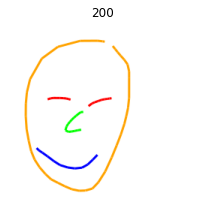

5


In [27]:
# print(dict(filter(lambda x: x[0][0] == idx, M_name.items())))

rd.show_these_sketches(
    CONST.face_json,
    [idx], 
    [str(idx)], 
    [[]], 
    num_pngs_per_row = 6,
    row_figsize = 4,
    column_figsize = 4,
)

strokes_spline_fitted = rd.process_quickdraw_to_stroke_no_normalize(
    drawing_arr[idx], 
    b_spline_num_sampled_points=200,
)
print(len(strokes_spline_fitted))

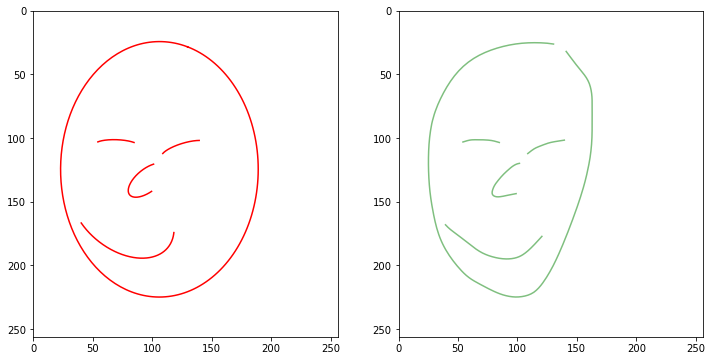

In [28]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

for index, entry in dfa[dfa.image == idx].iterrows():
    data = strokes_spline_fitted[entry.stroke]
    template_func = rd.TEMPLATE_DICT[entry.primitive]
    template = template_func(n)
    
    result, mse = rd.get_transformed_template(template, data, entry.M.reshape(3,3),projective=True)
#     ax1.plot(result[:,0], result[:,1], label="transformed template", s=1, c='r')
#     ax2.plot(data[:,0], data[:,1], label="data", alpha=0.5, s=1, c='g')
    
    ax1.plot(result[:,0], result[:,1], label="transformed template", c='r')
    ax2.plot(data[:,0], data[:,1], label="data", alpha=0.5,c='g')

# plt.legend()
# plt.xlim(0,w)
# plt.ylim(h,0)

ax1.axis(xmin=0,xmax=w)
ax1.axis(ymin=h,ymax=0)

ax2.axis(xmin=0,xmax=w)
ax2.axis(ymin=h,ymax=0)

plt.show()

In [25]:
dfa[dfa.image == idx]

,image,stroke,M,primitive,mse
4,1,0,"[0.07426618644942073, -0.7638244586723916, 209...",circle,158.619724
5,1,1,"[0.02277092619178832, 0.002682955158747209, 65...",zigzag1,0.004116
6,1,2,"[0.06515558285921869, -0.008265851324530662, 9...",zigzag1,0.013813
7,1,3,"[0.19429706094749774, -0.30443076333717334, 13...",square,68.302203


In [69]:
dfa[dfa.image == idx].M[98].reshape((3,3))

array([[  0.0125,  -0.1637,  92.6791],
       [ -0.0799,   0.044 , 128.9623],
       [  0.0007,  -0.0002,   1.    ]])

In [70]:
dfa[dfa.image == idx].M[99].reshape((3,3))

array([[  0.2515,  -0.0641,  93.3506],
       [  0.0989,  -0.1843, 134.0549],
       [  0.0011,  -0.0004,   1.    ]])

In [59]:
# dfn = new_df_pair()
dfo = pd.read_csv('/raid/xiaoyuz1/amazon_turk/df_all.csv')
dfo['no_punc_1'] = dfo.no_punc_1.apply(lambda x: [str(y).strip()[1:-1] for y in x[1:-1].split(',')])
# dfn = new_df_pair()
dfp = pd.read_csv('/raid/xiaoyuz1/amazon_turk/df_all_pair.csv')
dfp['no_punc_1'] = dfp.no_punc_1.apply(lambda x: [str(y).strip()[1:-1] for y in x[1:-1].split(',')])
dfp['no_punc_2'] = dfp.no_punc_2.apply(lambda x: [str(y).strip()[1:-1] for y in x[1:-1].split(',')])

In [61]:
dfo[(dfo['image_1'] == idx)]

,image_1,worker_id,part,category,time,folder,text_1,tokenized_1,lower_1,no_punc_1,no_punc_str_1
227,18,AKQAI78JTXXC9,4,face,366.0,/raid/xiaoyuz1/amazon_turk/2022_03_21_release,spiky hair,"['spiky', 'hair']","['spiky', 'hair']","[spiky, hair]",spiky hair
231,18,APRZ7BR8C0ZMQ,0,face,106.2,/raid/xiaoyuz1/amazon_turk/2022_03_21_release,happy,['happy'],['happy'],[happy],happy
466,18,A24LB89P1BPKKF,4,face,433.4,/raid/xiaoyuz1/amazon_turk/2022_03_21_release,"pointy, straight","['pointy', ',', 'straight']","['pointy', ',', 'straight']","[pointy, straight]",pointy straight
1288,18,A320QA9HJFUOZO,0,face,719.0,/raid/xiaoyuz1/amazon_turk/2022_03_22_release,round tall,"['round', 'tall']","['round', 'tall']","[round, tall]",round tall
2127,18,A12R2U6TBB3OOG,6,face,137.0,/raid/xiaoyuz1/amazon_turk/2022_03_23_release_2,"circular, even","['circular', ',', 'even']","['circular', ',', 'even']","[circular, even]",circular even
2600,18,A1DMXEJGJY02E1,2,face,73.4,/raid/xiaoyuz1/amazon_turk/2022_03_24_release,curved,['curve'],['curve'],[curve],curve
2625,18,A2QX3YJXAAHHVV,0,face,513.8,/raid/xiaoyuz1/amazon_turk/2022_03_24_release,"asymmetrical, lumpy, oval","['asymmetrical', ',', 'lumpy', ',', 'oval']","['asymmetrical', ',', 'lumpy', ',', 'oval']","[asymmetrical, lumpy, oval]",asymmetrical lumpy oval
2961,18,A2K6VG008QFOPN,0,face,687.8,/raid/xiaoyuz1/amazon_turk/2022_03_24_release,Big round,"['big', 'round']","['big', 'round']","[big, round]",big round
3972,18,A2NAKIXS3DVGAA,6,face,201.2,/raid/xiaoyuz1/amazon_turk/2022_04_04_release,egg-shaped,"['egg', '-']","['egg', '-']",[egg],egg
4150,18,A38DXFI1TZA295,2,face,119.4,/raid/xiaoyuz1/amazon_turk/2022_04_04_release,U-shaped,"['u', '-']","['u', '-']",[u],u


In [135]:
reload(rd)
M_arr_idx, M_name_idx, M_mse_idx = {},{},{}

template_dict = {
    #'arc' : lambda n : rd.generate_arc(n1=n),
    'circle' : lambda n : rd.generate_circle(n1=n, radius=100, x0=100, y0=100, template_size=256),
    'square' : lambda n : rd.generate_square(n1=n, template_size=256),
    'semicircle' : lambda n : rd.generate_semicircle(n1=n, radius=100, x0=100, y0=100, template_size=256),
    'zigzag3' : lambda n : rd.generate_zigzag3(n1=n, template_size=256),
    #'zigzag1' : lambda n : rd.generate_zigzag1(n1=n, template_size=256),
    'zigzag5' : lambda n : rd.generate_zigzag(n1=n,num_fold=5, template_size=256),
    'zigzag7' : lambda n : rd.generate_zigzag(n1=n,num_fold=7, template_size=256),
    'zigzag10' : lambda n : rd.generate_zigzag(n1=n,num_fold=10, template_size=256),
}


for stroke_index, data in enumerate(strokes_spline_fitted):
    mat, prim_name, prim_mse = rd.get_transform_smallest_mse(data, template_dict, \
                                                            n=200, use_projective=True)
    M_arr_idx[(idx, stroke_index)] = mat
    M_name_idx[(idx, stroke_index)] = prim_name
    M_mse_idx[(idx, stroke_index)] = prim_mse

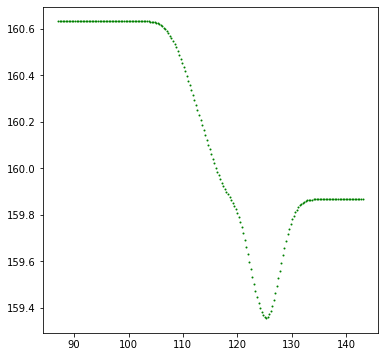

In [128]:
plt.figure(figsize=(6,6))
stroke_i = strokes_spline_fitted[5]
# mask = np.zeros(len(data))
# mask[:20] = 1
# np.random.shuffle(mask)
# stroke_i = data + (np.random.normal(0, 0.05, len(data)) * mask).reshape(-1,1)
plt.scatter(stroke_i[:,0], stroke_i[:,1], label="template", s=1, c='g')
# plt.xlim(0,w)
# plt.ylim(h,0)
plt.show()

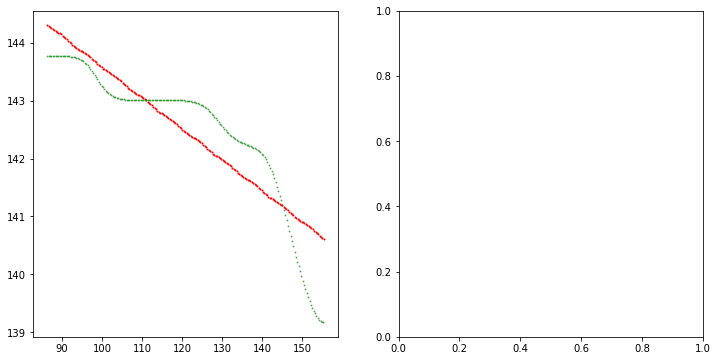

In [138]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

for k, M in M_arr_idx.items():
    if k[1] != 3:
        continue
    data = strokes_spline_fitted[k[1]]
    template_func = template_dict[M_name_idx[k]]
    template = template_func(n)
    
    result, mse = rd.get_transformed_template(template, data, M.reshape(3,3),projective=True)
    ax1.scatter(result[:,0], result[:,1], label="transformed template", s=1, c='r')
    ax1.scatter(data[:,0], data[:,1], label="data", alpha=0.5, s=1, c='g')

# plt.legend()
# plt.xlim(0,w)
# plt.ylim(h,0)

# ax1.axis(xmin=0,xmax=w)
# ax1.axis(ymin=h,ymax=0)

# ax2.axis(xmin=0,xmax=w)
# ax2.axis(ymin=h,ymax=0)

plt.show()

In [103]:
data = strokes_spline_fitted[stroke_idx]

96     [0.42410748886672833, -0.4494952153664001, 109...
97     [-0.21543212411260204, 0.026381272613180722, 1...
98     [0.012454767765860896, -0.16372540669478478, 9...
99     [0.25145659458290953, -0.0640982518445009, 93....
100    [0.048240438971921956, 0.4190080988050944, 55....
101    [-0.7491480149913262, 0.09135068226962952, 95....
102    [-0.12692410094280748, 0.707983575997115, 139....
Name: M, dtype: object

2.9199214787598444e-06


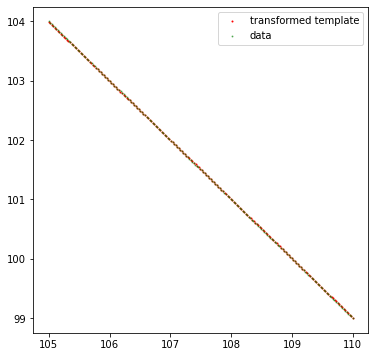

In [76]:
data = strokes_spline_fitted[stroke_idx]
template_func = rd.TEMPLATE_DICT[M_name[(idx, stroke_idx)]]
template = template_func(n)

result, mse = rd.get_transformed_template(template, data, M_arr[(idx, stroke_idx)].reshape(3,3))

print(mse)

datacolors = rd.get_sequence_colors(n, plt.cm.Greens)
templatecolors = rd.get_sequence_colors(n, plt.cm.Reds)

plt.figure(figsize=(6, 6))
# plt.scatter(result[:,0], result[:,1], label="transformed template", s=1, \
#             c=templatecolors)
# plt.scatter(data[:,0], data[:,1], label="data", alpha=0.5, s=1, c=datacolors)

plt.scatter(result[:,0], result[:,1], label="transformed template", s=1, c='r')
plt.scatter(data[:,0], data[:,1], label="data", alpha=0.5, s=1, c='g')

plt.legend()
# plt.xlim(0,w)
# plt.ylim(h,0)

plt.show()

In [14]:
reload(rd)

<module 'read_datasets' from '/home/xiaoyuz1/amazon_turk/read_datasets.py'>

In [49]:
data = strokes_spline_fitted[stroke_idx]

In [23]:

print(M_name[(idx, stroke_idx)])

template_func = rd.TEMPLATE_DICT[M_name[(idx, stroke_idx)]]

circle


In [24]:
projectiveM = M_arr[(idx, stroke_idx)]
template = template_func(n)
src_pts = template.astype(np.float32).reshape(-1,1,2)
result = cv2.perspectiveTransform(src_pts, projectiveM.reshape(3,3)).reshape(-1,2)

In [58]:
# calculate ourselves
template_func = rd.TEMPLATE_DICT['zigzag1']
template = template_func(n)

# template = rd.generate_zigzag(num_fold=10)
M, result = rd.get_transform(template, data, projective=True)

In [59]:
data.shape, template.shape

((200, 2), (200, 2))

0.00017625007577857225


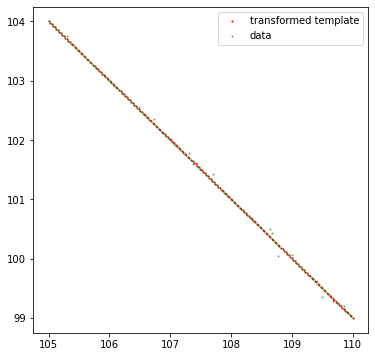

In [60]:
mse = mean_squared_error(result, data)
print(mse)

datacolors = rd.get_sequence_colors(n, plt.cm.Greens)
templatecolors = rd.get_sequence_colors(n, plt.cm.Reds)

plt.figure(figsize=(6, 6))
# plt.scatter(result[:,0], result[:,1], label="transformed template", s=1, \
#             c=templatecolors)
# plt.scatter(data[:,0], data[:,1], label="data", alpha=0.5, s=1, c=datacolors)

plt.scatter(result[:,0], result[:,1], label="transformed template", s=1, c='r')
plt.scatter(data[:,0], data[:,1], label="data", alpha=0.5, s=1, c='g')

plt.legend()
# plt.xlim(0,w)
# plt.ylim(h,0)

plt.show()

In [ ]:
import cv2
import numpy as np
import sys
from numpy.random import *

In [ ]:
def del_miss(indeces, dist, max_dist, th_rate = 0.8):
    th_dist = max_dist * th_rate
    return np.array([indeces[0][np.where(dist.T[0] < th_dist)]])


In [ ]:
def is_converge(Tr, scale):
    delta_angle = 0.0001
    delta_scale = scale * 0.0001
    
    min_cos = 1 - delta_angle
    max_cos = 1 + delta_angle
    min_sin = -delta_angle
    max_sin = delta_angle
    min_move = -delta_scale
    max_move = delta_scale
    
    return min_cos < Tr[0, 0] and Tr[0, 0] < max_cos and \
           min_cos < Tr[1, 1] and Tr[1, 1] < max_cos and \
           min_sin < -Tr[1, 0] and -Tr[1, 0] < max_sin and \
           min_sin < Tr[0, 1] and Tr[0, 1] < max_sin and \
           min_move < Tr[0, 2] and Tr[0, 2] < max_move and \
           min_move < Tr[1, 2] and Tr[1, 2] < max_move

In [ ]:
def icp(d1, d2, max_iterate = 100):
    src = np.array([d1.T], copy=True).astype(np.float32)
    dst = np.array([d2.T], copy=True).astype(np.float32)
    
    knn = cv2.KNearest()
    responses = np.array(range(len(d2[0]))).astype(np.float32)
    knn.train(src[0], responses)
        
    Tr = np.array([[np.cos(0), -np.sin(0), 0],
                   [np.sin(0), np.cos(0),  0],
                   [0,         0,          1]])

    dst = cv2.transform(dst, Tr[0:2])
    max_dist = sys.maxint
    
    scale_x = np.max(d1[0]) - np.min(d1[0])
    scale_y = np.max(d1[1]) - np.min(d1[1])
    scale = max(scale_x, scale_y)
       
    for i in range(max_iterate):
        ret, results, neighbours, dist = knn.find_nearest(dst[0], 1)
        
        indeces = results.astype(np.int32).T     
        indeces = del_miss(indeces, dist, max_dist)  
        
        T = cv2.estimateRigidTransform(dst[0, indeces], src[0, indeces], True)

        max_dist = np.max(dist)
        dst = cv2.transform(dst, T)
        Tr = np.dot(np.vstack((T,[0,0,1])), Tr)
        
        if (is_converge(T, scale)):
            break
        
    return Tr[0:2]

In [ ]:
if __name__ == "__main__":
    import matplotlib.pyplot as plt
    
    point_count = 100
    th = np.pi / 8
    move = np.array([[0.30], [0.5]])
    rnd_scale = 0.03
    x1 = np.linspace(0, 1.1, point_count)
    y1 = np.sin(x1 * np.pi)
    d1 = np.array([x1, y1])

    rot = np.array([[np.cos(th), -np.sin(th)], [np.sin(th), np.cos(th)]])
    rand = np.random.rand(2, point_count)*rnd_scale
    d2 = np.dot(rot, d1) + move
    d2 = np.add(d2, rand)

    plt.plot(d1[0], d1[1])
    plt.plot(d2[0], d2[1])
    plt.show()

In [ ]:
    ret = icp(d1, d2)
    
    plt.plot(d1[0], d1[1])
    dst = np.array([d2.T], copy=True).astype(np.float32)
    dst = cv2.transform(dst, ret)
    plt.plot(dst[0].T[0], dst[0].T[1])
    plt.show()
    
    print ret[0][0] * ret[0][0] + ret[0][1] * ret[0][1]
    print np.arccos(ret[0][0]) / 2 / np.pi * 360
    print np.arcsin(ret[0][1]) / 2 / np.pi * 360

    print ret

In [ ]:
def icp(a, b,
        max_time = 1
    ):
    import cv2
    import numpy
    import copy
    import pylab
    import time
    import sys
    import sklearn.neighbors
    import scipy.optimize



    def res(p,src,dst):
        T = numpy.matrix([[numpy.cos(p[2]),-numpy.sin(p[2]),p[0]],
        [numpy.sin(p[2]), numpy.cos(p[2]),p[1]],
        [0 ,0 ,1 ]])
        n = numpy.size(src,0)
        xt = numpy.ones([n,3])
        xt[:,:-1] = src
        xt = (xt*T.T).A
        d = numpy.zeros(numpy.shape(src))
        d[:,0] = xt[:,0]-dst[:,0]
        d[:,1] = xt[:,1]-dst[:,1]
        r = numpy.sum(numpy.square(d[:,0])+numpy.square(d[:,1]))
        return r

    def jac(p,src,dst):
        T = numpy.matrix([[numpy.cos(p[2]),-numpy.sin(p[2]),p[0]],
        [numpy.sin(p[2]), numpy.cos(p[2]),p[1]],
        [0 ,0 ,1 ]])
        n = numpy.size(src,0)
        xt = numpy.ones([n,3])
        xt[:,:-1] = src
        xt = (xt*T.T).A
        d = numpy.zeros(numpy.shape(src))
        d[:,0] = xt[:,0]-dst[:,0]
        d[:,1] = xt[:,1]-dst[:,1]
        dUdth_R = numpy.matrix([[-numpy.sin(p[2]),-numpy.cos(p[2])],
                            [ numpy.cos(p[2]),-numpy.sin(p[2])]])
        dUdth = (src*dUdth_R.T).A
        g = numpy.array([  numpy.sum(2*d[:,0]),
                        numpy.sum(2*d[:,1]),
                        numpy.sum(2*(d[:,0]*dUdth[:,0]+d[:,1]*dUdth[:,1])) ])
        return g
    
    def hess(p,src,dst):
        n = numpy.size(src,0)
        T = numpy.matrix([[numpy.cos(p[2]),-numpy.sin(p[2]),p[0]],
        [numpy.sin(p[2]), numpy.cos(p[2]),p[1]],
        [0 ,0 ,1 ]])
        n = numpy.size(src,0)
        xt = numpy.ones([n,3])
        xt[:,:-1] = src
        xt = (xt*T.T).A
        d = numpy.zeros(numpy.shape(src))
        d[:,0] = xt[:,0]-dst[:,0]
        d[:,1] = xt[:,1]-dst[:,1]
        dUdth_R = numpy.matrix([[-numpy.sin(p[2]),-numpy.cos(p[2])],[numpy.cos(p[2]),-numpy.sin(p[2])]])
        dUdth = (src*dUdth_R.T).A
        H = numpy.zeros([3,3])
        H[0,0] = n*2
        H[0,2] = numpy.sum(2*dUdth[:,0])
        H[1,1] = n*2
        H[1,2] = numpy.sum(2*dUdth[:,1])
        H[2,0] = H[0,2]
        H[2,1] = H[1,2]
        d2Ud2th_R = numpy.matrix([[-numpy.cos(p[2]), numpy.sin(p[2])],[-numpy.sin(p[2]),-numpy.cos(p[2])]])
        d2Ud2th = (src*d2Ud2th_R.T).A
        H[2,2] = numpy.sum(2*(numpy.square(dUdth[:,0])+numpy.square(dUdth[:,1]) + d[:,0]*d2Ud2th[:,0]+d[:,0]*d2Ud2th[:,0]))
        return H
    
    
    t0 = time.time()
    init_pose = (0,0,0)
    src = numpy.array([a.T], copy=True).astype(numpy.float32)
    dst = numpy.array([b.T], copy=True).astype(numpy.float32)
    Tr = numpy.array([[numpy.cos(init_pose[2]),-numpy.sin(init_pose[2]),init_pose[0]],
                   [numpy.sin(init_pose[2]), numpy.cos(init_pose[2]),init_pose[1]],
                   [0,                    0,                   1          ]])
    print("src",numpy.shape(src))
    print("Tr[0:2]",numpy.shape(Tr[0:2]))
    src = cv2.transform(src, Tr[0:2])
    p_opt = numpy.array(init_pose)
    T_opt = numpy.array([])
    error_max = sys.maxsize
    first = False
    while not(first and time.time() - t0 > max_time):
        distances, indices = sklearn.neighbors.NearestNeighbors(n_neighbors=1, algorithm='auto',p = 3).fit(dst[0]).kneighbors(src[0])
        p = scipy.optimize.minimize(res,[0,0,0],args=(src[0],dst[0, indices.T][0]),method='Newton-CG',jac=jac,hess=hess).x
        T  = numpy.array([[numpy.cos(p[2]),-numpy.sin(p[2]),p[0]],[numpy.sin(p[2]), numpy.cos(p[2]),p[1]]])
        p_opt[:2]  = (p_opt[:2]*numpy.matrix(T[:2,:2]).T).A       
        p_opt[0] += p[0]
        p_opt[1] += p[1]
        p_opt[2] += p[2]
        src = cv2.transform(src, T)
        Tr = (numpy.matrix(numpy.vstack((T,[0,0,1])))*numpy.matrix(Tr)).A
        error = res([0,0,0],src[0],dst[0, indices.T][0])

        if error < error_max:
            error_max = error
            first = True
            T_opt = Tr

    p_opt[2] = p_opt[2] % (2*numpy.pi)
    return T_opt, error_max


def main():
    import cv2
    import numpy
    import random
    import matplotlib.pyplot
    n1 = 100
    n2 = 75
    bruit = 1/10
    center = [random.random()*(2-1)*3,random.random()*(2-1)*3]
    radius = random.random()
    deformation = 2

    template = numpy.array([
        [numpy.cos(i*2*numpy.pi/n1)*radius*deformation for i in range(n1)], 
        [numpy.sin(i*2*numpy.pi/n1)*radius for i in range(n1)]
    ])

    data = numpy.array([
        [numpy.cos(i*2*numpy.pi/n2)*radius*(1+random.random()*bruit)+center[0] for i in range(n2)], 
        [numpy.sin(i*2*numpy.pi/n2)*radius*deformation*(1+random.random()*bruit)+center[1] for i in range(n2)]
    ])

    T,error = icp(data,template)
    dx = T[0,2]
    dy = T[1,2]
    rotation = numpy.arcsin(T[0,1]) * 360 / 2 / numpy.pi

    print("T",T)
    print("error",error)
    print("rotation°",rotation)
    print("dx",dx)
    print("dy",dy)

    result = cv2.transform(numpy.array([data.T], copy=True).astype(numpy.float32), T).T
    matplotlib.pyplot.plot(template[0], template[1], label="template")
    matplotlib.pyplot.plot(data[0], data[1], label="data")
    matplotlib.pyplot.plot(result[0], result[1], label="result: "+str(rotation)+"° - "+str([dx,dy]))
    matplotlib.pyplot.legend(loc="upper left")
    matplotlib.pyplot.axis('square')
    matplotlib.pyplot.show()

if __name__ == "__main__":
    main()